# Load required packages

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import spacy
nlp = spacy.load("en_core_web_sm")
import chardet
from nltk.corpus import stopwords

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import re
import numpy as np

In [5]:
# pip install pyLDAvis

# Preprocess the dataframe


In [6]:
text = pd.read_excel("DraftMv1.xlsx")
text = text[['Comments']]
text.head()

,Comments
0,its heading in the right direction. completely...
1,for the environment. extremely small residenti...
2,"to preserving the bushland, commitment to ensu..."
3,N/A. bus service for dont want town houses at ...
4,"there is a strategy, and subsequently a plan....."


In [7]:
text.shape

(308, 1)

#### Define a function for removing unwanted characters in the text


In [8]:
import re
def clean_text(doc):
    doc = re.sub('[^A-Za-z0-9. /,]', ' ', doc)
    doc = re.sub('/', ', ', doc)
    doc = re.sub(',', ' ', doc)
    doc = re.sub(' +', ' ', doc)
    doc = doc.lower()
    return doc

#### With lambda expression, remove the unwanted characers and put the results into a new column called "cleaned_text"

In [9]:
text["cleaned_text"] = text["Comments"].apply(lambda x: clean_text(x))
text.head()

,Comments,cleaned_text
0,its heading in the right direction. completely...,its heading in the right direction. completely...
1,for the environment. extremely small residenti...,for the environment. extremely small residenti...
2,"to preserving the bushland, commitment to ensu...",to preserving the bushland commitment to ensur...
3,N/A. bus service for dont want town houses at ...,n a. bus service for dont want town houses at ...
4,"there is a strategy, and subsequently a plan.....",there is a strategy and subsequently a plan.. ...


#### Put every sentence in a row of a dataframe and call it "data"

In [10]:
def sentence_segmentation(text):
    final = []
    for i in range(len(text["cleaned_text"])):
        doc = nlp(text["cleaned_text"][i])
        for sent in doc.sents:
            content = [None,None].copy()
            content[0] = i+1
            content[1] = sent.text
            final.append(content)
    data = pd.DataFrame(final)
    data.columns = ["comment number", "sentence"]
    return data

In [11]:
data = sentence_segmentation(text)
data.head()

,comment number,sentence
0,1,its heading in the right direction.
1,1,completely understand there are time frames wo...
2,1,is imperative that there are options for young...
3,1,lacks infrastructure in these areas.
4,1,would be good to see a shopping complex and la...


#### Use Term-Frequency Inverse Document Frequency to convert words to vectors on numbers

In [12]:
tfidf = TfidfVectorizer(max_df=0.85, min_df=0.01, stop_words='english')
dtm = tfidf.fit_transform(data['sentence'])
dtm

<1967x144 sparse matrix of type '<class 'numpy.float64'>'
	with 6624 stored elements in Compressed Sparse Row format>

In [13]:
LDA = LatentDirichletAllocation() # Create an instance of the function

#### Use grid search to find the optimum hypter parameters 

In [14]:
# Fit LDA to the vector of corpus
LDA = LatentDirichletAllocation(n_components=4, learning_decay = 0.5, random_state=67, max_iter=150)
LDA.fit(dtm)

LatentDirichletAllocation(learning_decay=0.5, max_iter=150, n_components=4,
                          random_state=67)

#### A function to print the words with the highest probability in each topc

In [15]:
def top_words(LDA, n):
    for index,topic in enumerate(LDA.components_):
        print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
        print([tfidf.get_feature_names()[i] for i in topic.argsort()[-n:]])
        print('\n')

In [16]:
top_words(LDA, 12)

THE TOP 10 WORDS FOR TOPIC #0
['feel', 'does', 'people', 'suburb', 'new', 'lot', 'plan', 'connection', 'needs', 'access', 'traffic', 'road']


THE TOP 10 WORDS FOR TOPIC #1
['area', 'school', 'types', 'density', 'infrastructure', 'train', 'land', 'public', 'station', 'transport', 'proforma', 'housing']


THE TOP 10 WORDS FOR TOPIC #2
['large', 'plan', 'natural', 'future', 'area', 'kedron', 'development', 'bushland', 'strategy', 'community', 'areas', 'rd']


THE TOP 10 WORDS FOR TOPIC #3
['roads', 'cars', 'don', 'existing', 'like', 'current', 'just', 'need', 'residents', 'local', 'area', 'development']




# Visualize the topic clustering

In [17]:
pyLDAvis.enable_notebook()
pane = pyLDAvis.sklearn.prepare(LDA, dtm, tfidf)
pyLDAvis.save_html(pane, 'output_filename.html')
pane

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.156338 -0.283060       1        1  26.281373
1     -0.215722  0.234318       2        1  24.916914
0      0.295320  0.011684       3        1  24.624672
3      0.076741  0.037058       4        1  24.177041, topic_info=    Category        Freq         Term       Total  loglift  logprob
106  Default  109.000000         road  109.000000  30.0000  30.0000
58   Default   56.000000      housing   56.000000  29.0000  29.0000
0    Default   66.000000       access   66.000000  28.0000  28.0000
131  Default   80.000000      traffic   80.000000  27.0000  27.0000
98   Default   49.000000     proforma   49.000000  26.0000  26.0000
..       ...         ...          ...         ...      ...      ...
33    Topic4   45.197560  development   85.549590   0.7817  -2.8130
3     Topic4   35.922730         area   95.062575   0.4466  -3.0427
107   Topic4   19.318992        roads   37.161337   0.7656  -3.6630
131   Topic4   18.903249      traffic   80.296085  -0.0266  -3.6847
94    Topic4   16.341227         plan   65.412183   0.0327  -3.8304

[169 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.090207      access
0         3  0.902065      access
1         2  0.292804  additional
1         3  0.585608  additional
1         4  0.117122  additional
...     ...       ...         ...
140       3  0.922584         use
141       3  0.982779    vehicles
142       1  0.661301         way
142       2  0.283415         way
143       3  0.959022       years

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

#### Based on the words we can determine the topic for title every sentence

In [18]:
topic_results = LDA.transform(dtm)
data['topic'] = topic_results.argmax(axis=1)
data['Development'] = 0
data['Transport'] = 0
data['Surroundings'] = 0
data['Hospitality'] = 0
data.reset_index(inplace = True)


for i in range(len(data)):
    if data['topic'][i] == 0:
        data['Surroundings'][i] = 1
    if data['topic'][i] == 1:
        data['Hospitality'][i] = 1
    if data['topic'][i] == 2:
        data['Development'][i] = 1
    if data['topic'][i] == 3:
        data['Transport'][i] = 1

In [19]:
data.to_csv("results.csv", index = False)
data.head(10)

,index,comment number,sentence,topic,Development,Transport,Surroundings,Hospitality
0,0,1,its heading in the right direction.,0,0,0,1,0
1,1,1,completely understand there are time frames wo...,3,0,1,0,0
2,2,1,is imperative that there are options for young...,2,1,0,0,0
3,3,1,lacks infrastructure in these areas.,1,0,0,0,1
4,4,1,would be good to see a shopping complex and la...,1,0,0,0,1
5,5,1,of green space linked to the natural bushland ...,2,1,0,0,0
6,6,1,much looking forward to the changes about to h...,0,0,0,1,0
7,7,2,for the environment.,2,1,0,0,0
8,8,2,extremely small residential blocks narrow stre...,2,1,0,0,0
9,9,2,should also be full access to road is already ...,0,0,0,1,0


# Preprocess for Neural Networks

#### Remove stop words from sentences

In [20]:
data = pd.read_csv("results.csv")
data.head()

,index,comment number,sentence,topic,Development,Transport,Surroundings,Hospitality
0,0,1,its heading in the right direction.,0,0,0,1,0
1,1,1,completely understand there are time frames wo...,3,0,1,0,0
2,2,1,is imperative that there are options for young...,2,1,0,0,0
3,3,1,lacks infrastructure in these areas.,1,0,0,0,1
4,4,1,would be good to see a shopping complex and la...,1,0,0,0,1


In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zeina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop = stopwords.words('english')
data['sentence'] = data['sentence'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
data.head(10)

,index,comment number,sentence,topic,Development,Transport,Surroundings,Hospitality
0,0,1,heading right direction.,0,0,0,1,0
1,1,1,completely understand time frames would like s...,3,0,1,0,0
2,2,1,imperative options young families shop dine mo...,2,1,0,0,0
3,3,1,lacks infrastructure areas.,1,0,0,0,1
4,4,1,would good see shopping complex lake parklands...,1,0,0,0,1
5,5,1,green space linked natural bushland setting.,2,1,0,0,0
6,6,1,much looking forward changes happen cant happe...,0,0,0,1,0
7,7,2,environment.,2,1,0,0,0
8,8,2,extremely small residential blocks narrow stre...,2,1,0,0,0
9,9,2,also full access road already burdened traffic...,0,0,0,1,0


#### Create x and y for training the network

In [23]:
x = data["sentence"]
y = data[["Development", "Transport", "Surroundings", "Hospitality"]].values

In [24]:
y.sum(axis = 0) # The number grouped by class label

array([461, 416, 667, 423], dtype=int64)

#### split train and text data for training

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=17)

#### Tokenize the words and pad sequences in order to unify length of sentences (Length of vocab is important)

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

3205

#### Define length of each word! This way is good for obtaining sentiment from words

In [27]:
maxlen = 300
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

# Create neural network model

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout, Conv1D, GlobalAveragePooling1D
from keras.optimizers import SGD, Adam

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 300, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          961500    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4100      
Total params: 1,273,824
Trainable params: 1,273,824
Non-trainable params: 0
_________________________________________________________________


#### We need to compile the model before training
This model can reduce learning rate to prevent jumps over local extremes.
Check point enables the program to save the best model based on accuracy.

In [29]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
rlcp = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode = 'min',patience=5, verbose=1, min_lr=0.00001)]

#### Train the model

In [30]:
model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    callbacks = rlcp)

Train on 1671 samples, validate on 296 samples
Epoch 1/20
1671/1671 [==============================] - 1s 725us/step - loss: 1.3715 - categorical_accuracy: 0.3285 - val_loss: 1.3716 - val_categorical_accuracy: 0.3277
Epoch 2/20
1671/1671 [==============================] - 1s 654us/step - loss: 1.3655 - categorical_accuracy: 0.3411 - val_loss: 1.3696 - val_categorical_accuracy: 0.3277
Epoch 3/20
1671/1671 [==============================] - 1s 672us/step - loss: 1.3630 - categorical_accuracy: 0.3411 - val_loss: 1.3680 - val_categorical_accuracy: 0.3277
Epoch 4/20
1671/1671 [==============================] - ETA: 0s - loss: 1.3608 - categorical_accuracy: 0.34 - 1s 663us/step - loss: 1.3608 - categorical_accuracy: 0.3411 - val_loss: 1.3640 - val_categorical_accuracy: 0.3277
Epoch 5/20
1671/1671 [==============================] - 1s 679us/step - loss: 1.3528 - categorical_accuracy: 0.3417 - val_loss: 1.3548 - val_categorical_accuracy: 0.3277
Epoch 6/20
1671/1671 [===========================

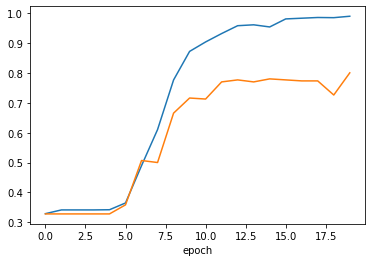

In [31]:
import matplotlib.pyplot as plt

tr_acc = model.history.history['categorical_accuracy']
val_acc = model.history.history['val_categorical_accuracy']
tr_loss = model.history.history['loss']
tr_loss = tr_loss/np.array(tr_loss).max()
val_loss = model.history.history['val_loss']/np.array(tr_loss).max()



#plt.plot(tr_loss, label = "train loss")
#plt.plot(val_loss, label = "validation loss")
plt.plot(tr_acc, label = "train accuracy")
plt.plot(val_acc, label = "validation accuracy")
plt.xlabel('epoch')
plt.savefig('trainval_acc.png')

In [32]:
from keras.models import load_model
model.save("sentence_classificatio.h5")
model = load_model("sentence_classificatio.h5")

# Prediction on new data

In [33]:
# Function to read csv
def read_mycsv(path):
    with open(path, 'rb') as f:
        result = chardet.detect(f.read())
    return pd.read_csv(path, encoding=result['encoding'])

In [34]:
text = read_mycsv("text.csv")
text.head()

,Original text
0,I strongly against the plan of building 5 stor...
1,"""believe there are a number of issues that nee..."
2,a resident of and a frequent traveller on the...
3,"I have just built a new home in Road, Kedron. ..."
4,I would like to express my concerns with the p...


#### Preprocess the text in the column named "comment"

In [35]:
text.columns = ["comment"]
text.dropna(inplace = True)
text.reset_index(inplace = True, drop = True)
text["cleaned_text"] = text["comment"].apply(lambda x: clean_text(x))
text.head()

,comment,cleaned_text
0,I strongly against the plan of building 5 stor...,i strongly against the plan of building 5 stor...
1,"""believe there are a number of issues that nee...",believe there are a number of issues that nee...
2,a resident of and a frequent traveller on the...,a resident of and a frequent traveller on the...
3,"I have just built a new home in Road, Kedron. ...",i have just built a new home in road kedron. b...
4,I would like to express my concerns with the p...,i would like to express my concerns with the p...


#### extract all sentences from each cleaned text

In [36]:
def sentence_segmentation(text):
    final = []
    for i in range(len(text["cleaned_text"])):
        doc = nlp(text["cleaned_text"][i])
        for sent in doc.sents:
            content = [None,None].copy()
            content[0] = i+1
            content[1] = sent.text
            final.append(content)
    data = pd.DataFrame(final)
    data.columns = ["comment number", "sentence"]
    return data

In [37]:
# We should remove stop words too.
data = sentence_segmentation(text)
stop = stopwords.words('english')
data['cleaned_sentence'] = data['sentence'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
data.head(10)

,comment number,sentence,cleaned_sentence
0,1,i strongly against the plan of building 5 stor...,strongly plan building 5 storeys units denman ...
1,1,abound the hospital has already full of units ...,abound hospital already full units townhouses.
2,1,i am very concerned about the parking problem ...,concerned parking problem already complained p...
3,1,addition 5 storey building with ruin the overa...,addition 5 storey building ruin overall look b...
4,1,but not least i can t see any point of having ...,least see point residential buildings around h...
5,2,believe there are a number of issues that nee...,believe number issues need addressed developme...
6,2,d is located immediately to the west and south...,located immediately west south north.
7,2,subdivision pressures coming from the north east.,subdivision pressures coming north east.
8,2,2 is identified within footprint although at t...,2 identified within footprint although local p...
9,2,zoned rural and special facilities have signif...,zoned rural special facilities significant val...


#### Tokenize sentences and prepare them to input to the model

In [38]:
x = data["cleaned_sentence"]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, padding='post', maxlen=maxlen)
pred = model.predict(x)
pred = pd.DataFrame(np.round(pred), columns = ["Development", "Transport", "Surroundings", "Hospitality"])
pred["sentence"] = data["sentence"]
pred["comment ID"] = data["comment number"]

#### Group the sentences if they are from the same comment with same category

In [39]:
pred2 = pred.groupby(['comment ID', "Development", "Transport", "Surroundings", "Hospitality"])['sentence'].apply(lambda x: ' '.join(x)).reset_index()
pred2.head(10)

,comment ID,Development,Transport,Surroundings,Hospitality,sentence
0,1,0.0,0.0,0.0,0.0,i am very concerned about the parking problem ...
1,1,0.0,0.0,1.0,0.0,i strongly against the plan of building 5 stor...
2,1,0.0,1.0,0.0,0.0,but not least i can t see any point of having ...
3,1,1.0,0.0,0.0,0.0,addition 5 storey building with ruin the overa...
4,2,0.0,0.0,0.0,0.0,is in the upper catchment sediment entering th...
5,2,0.0,0.0,0.0,1.0,corridors are essential in maintaining brisban...
6,2,0.0,0.0,1.0,0.0,zoned rural and special facilities have signif...
7,2,0.0,1.0,0.0,0.0,believe there are a number of issues that nee...
8,2,1.0,0.0,0.0,0.0,d is located immediately to the west and south...
9,3,0.0,0.0,0.0,1.0,m concerned to note that not provision has bee...


In [40]:
pred2.to_csv("final_results_groupby_IDandLABEL.csv", index = False)

In [41]:
pred2.to_excel('finalResult1.xlsx', sheet_name='Topic Comments', index=False)